In [ ]:
# !pip install pyobb

In [1]:
import os
import sys
import yaml
import copy
import warnings
import importlib as imp
from datetime import datetime
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# import pcl
import pyntcloud

# sys.path.append('/home/jovyan/work/obstacle-detection/')
# # sys.path.append('/home/jovyan/work/boxes_vis/git/obstacle-detection/')

In [2]:
with open('../config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
obstacle_dct = config['obstacles']
leaning_map_obstacles = config['learning_map']
mapped_obstacles_lst = list(set([leaning_map_obstacles[id] for id in obstacle_dct.keys()]))

In [4]:
import sys
sys.path.append("..")

import model
# get_user = imp.reload(model)
from model.tasks.semantic import infer2
infer2 = imp.reload(infer2)

In [5]:
user = infer2.get_user("squeezeseg")

----------
INTERFACE:
model squeezeseg
----------

Opening arch config file from squeezeseg
Opening data config file from squeezeseg
model folder exists! Using model from squeezeseg
parser started
Using SqueezeNet Backbone
Depth of backbone input =  5
Original OS:  16
New OS:  16
Strides:  [2, 2, 2, 2]
Decoder original OS:  16
Decoder new OS:  16
Decoder strides:  [2, 2, 2, 2]
Total number of parameters:  915540
Total number of parameters requires_grad:  915540
Param encoder  724032
Param decoder  179968
Param head  11540
Successfully loaded model backbone weights
Successfully loaded model decoder weights
Successfully loaded model head weights
Infering in device:  cpu


In [6]:
%%time 
num = '066'
bin_path = '../dataset/sequences/00/velodyne/000' + num + '.bin'
scan = np.fromfile(bin_path, dtype=np.float32)
scan = scan.reshape((-1, 4))

CPU times: user 2.42 ms, sys: 4.7 ms, total: 7.12 ms
Wall time: 30.7 ms


In [8]:
from pipeline import pipeline
from pipeline import common
pipeline = imp.reload(pipeline)

In [9]:
scan = common.roi_filter(pd.DataFrame(scan, columns=['x', 'y', 'z', 'remission']),
                                              min_x = 0, max_x =  45,
                                              min_y =  -14, max_y =  14,
                                              min_z =  -2, max_z =  1)[['x', 'y', 'z', 'remission']].values


Input pcloud size: 121199
Output ROI pcloud size: 61527


In [14]:
scan

array([[20.252977  ,  9.396305  ,  0.95818377,  0.16      ],
       [20.143549  ,  9.422301  ,  0.9551727 ,  0.53      ],
       [14.351136  ,  7.389624  ,  0.7508579 ,  0.53      ],
       ...,
       [ 3.7858496 , -1.4187256 , -1.7453413 ,  0.36      ],
       [ 3.7884095 , -1.4067276 , -1.7443551 ,  0.32      ],
       [ 3.7909355 , -1.3937299 , -1.7433698 ,  0.        ]],
      dtype=float32)

In [11]:

%%time
params = {'roi_x_min': 0, 'roi_x_max': 45,
          'roi_y_min': -14, 'roi_y_max': 14,
          'roi_z_min': -2, 'roi_z_max': 1,
          'eps': 0.65, 'min_samples': 6, 'leaf_size': 120, 
          'proc_labels': False}  
start_time = datetime.now()
label = user.infer(scan)
# print('Segmentation time: {}'.format((datetime.now() - start_time).total_seconds()))
# clusters, cluster_data, time_exec = pipeline.pipeline(scan[:, :3], label, mapped_obstacles_lst, verbose=True, 
#                                     exec_time=True, **params)

CPU times: user 631 ms, sys: 13.5 ms, total: 644 ms
Wall time: 186 ms


In [13]:
label.__len__()

61527

In [76]:
import pyntcloud
test_cloud = pyntcloud.PyntCloud(cluster_data)
test_cloud.plot(use_as_color='cluster_id', cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(7.246531131896764, 16.887283441998246, 0.654…

![lol](img/seg_od_clustering.png)

In [50]:
np.savetxt('examples/000066.bbox', clusters)

![lol](img/seg_od_clustering_bbox_000066.png)

### Sequence: bboxes and stats getting

In [10]:
import glob
seq = '00'
scan_lst = sorted(glob.glob("../dataset/sequences/" + seq + "/velodyne/*.bin"))
labels_lst = sorted(glob.glob("../dataset/sequences/" + seq + "/labels/*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  459


In [11]:
from scripts import test
test = imp.reload(test)

In [12]:
%%time
# n_scan = -1
write_path = '../dataset/sequences/' + seq + '/clusters/'
# write_path = None
bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst, labels_lst, mapped_obstacles_lst,
                                                        pipeline.pipeline, write_path=write_path, seg_model=user,
                                                        OBB=False, detailed=True, **params)

User`s KeyboardInterruption...
CPU times: user 10min 13s, sys: 35.3 s, total: 10min 48s
Wall time: 4min 17s


In [13]:
steps = list(stats[0].keys())
steps_exec_time = []
for step in steps:
    steps_exec_time.append([stat[step] for stat in stats])

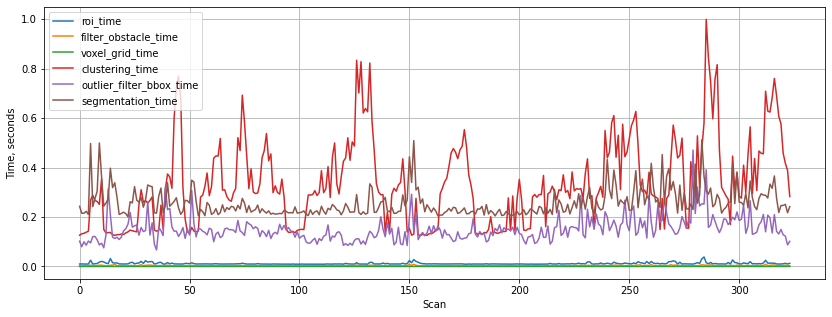

In [14]:
plt.figure(figsize=(14,5))
for i, step in enumerate(steps):
    plt.plot(steps_exec_time[i], label=step)
plt.legend(loc='best')
plt.xlabel('Scan')
plt.ylabel('Time, seconds')
plt.grid()
plt.show()

In [15]:
time_stat = list(exec_time_dct.values())
print('Min process time {} s'.format(min(time_stat)))
print('Mean process time {} s'.format(np.mean(time_stat)))
print('Max process time {} s'.format(max(time_stat)))

Min process time 0.438552 s
Mean process time 0.7562612623456789 s
Max process time 1.717411 s


In [16]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = time_stat

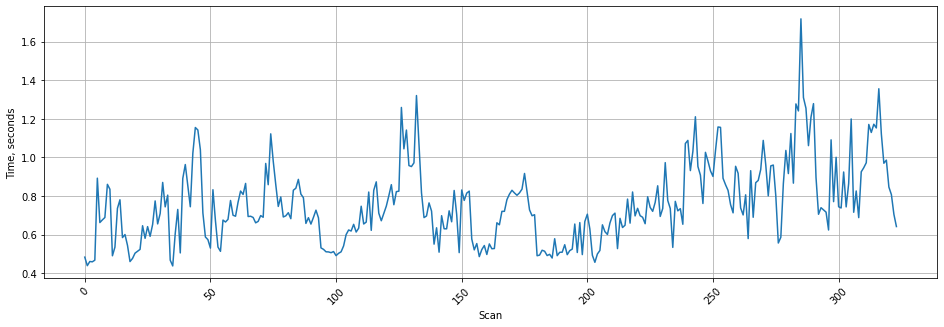

In [17]:
plt.figure(figsize=(16, 5))
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time, seconds')
plt.grid()
plt.xticks(rotation=45)
plt.show()